In [1]:
import os
import sys
import glob
import numpy as np
from scipy.signal import welch
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import FixedLocator, NullLocator, FixedFormatter
fontsize = 9
lw = 0.75
matplotlib.rc('font', **{'family': 'Arial', 'size': fontsize})
matplotlib.rc('axes', **{'linewidth': 0.75, 'labelsize': fontsize})
matplotlib.rc('xtick', **{'labelsize': fontsize})
matplotlib.rc('ytick', **{'labelsize': fontsize})
matplotlib.rc('xtick.major', **{'width': lw, 'size':3})
matplotlib.rc('ytick.major', **{'width': lw, 'size':3})
matplotlib.rc('ytick.minor', **{'width': lw, 'size':1.5})
OU_tau = 20e-3

In [2]:
network = 'Sardinia'
if network == 'IEEE39':
    PF_net_name = 'IEEE39_stoch'
    condition = 'default'
    load_type = 'static_const_Z'
    load_name = 'Loads_03_21'
    expt_name = os.path.join(condition,load_type,load_name)
    fmin, fmax, steps_per_decade = -6, 2, 1000
    outfile = 'TF_{}-{}-{}-{}'.format(PF_net_name, condition, load_type, load_name)
elif network == 'Sardinia':
    static_load = True
    if static_load:
        PF_net_name = 'V2020_Rete_Sardegna_2021_06_03cr_stoch'
        PF_net_name = 'V2020_Rete_Sard_2021_06_03cr_mod_loads'
        condition = 'FSACTI0201GGR3_double_H'
        load_name = 'EqX_NARCDI1501TRB_____LOAD____'
        dP = 0.01
        subdir = os.path.join('positive_load',f'dP_{dP:g}')
    else:
        PF_net_name = 'V2020_Rete_Sardegna_2021_06_03cr_stoch'
        condition = 'default'
        load_name = 'EqX_BNFC_I0601TRR_____LOAD____'
        dP = 0.01
        subdir = os.path.join(f'dP_{dP}')
    expt_name = os.path.join(condition, load_name, subdir)
    fmin, fmax, steps_per_decade = -6, 2, 100
    outfile = 'TF_{}-{}-{}'.format(PF_net_name, load_name, subdir.split(os.path.sep)[-1])
elif network in ('SM_with_load','SM_with_line_and_load','SM_with_line_and_loads'):
    PF_net_name = network
    load_type = 'static_load_const_Z'
    if 'loads' in network:
        expt_name = os.path.join(expt_name, 'LD1')
    fmin, fmax, steps_per_decade = -6, 2, 1000
    outfile = 'TF_{}-{}'.format(PF_net_name, expt_name.replace(os.path.sep,'-'))
else:
    raise Exception(f'Unknown network: "{network}"')
folder = os.path.join('..','..','modal_analysis',network,expt_name)
outfile = os.path.join(folder, outfile)
AC_data_file = os.path.join(folder, f'{PF_net_name}_AC_TF_{fmin:.1f}_{fmax:.1f}_{steps_per_decade}.npz')
AC_data = np.load(AC_data_file, allow_pickle=True)
dB = AC_data['dB'].item()

In [3]:
discard = 300 # [s]
tran_data_files = sorted(glob.glob(os.path.join(folder,f'{PF_net_name}_tran_*.npz')))
# tran_data_files = tran_data_files[1:]
print(f'Found {len(tran_data_files)} data files.')
tran_blobs = [np.load(f, allow_pickle=True) for f in tran_data_files]
time = [blob['time'] for blob in tran_blobs]
speed = [blob['data'].item()['gen']['s:xspeed'] for blob in tran_blobs]
if speed[0].ndim == 1:
    speed = [np.reshape(spd, (-1,1)) for spd in speed]
tran_speed = np.concatenate([spd[t>discard,:] for t,spd in zip(time, speed)], axis=0)
dt = time[0][1] - time[0][0]
tran_time = np.arange(tran_speed.shape[0]) * dt

Found 5 data files.


In [4]:
tran_M = tran_blobs[0]['momentum'].item()
AC_M = AC_data['Mtot'].item()
M = tran_M

In [5]:
fref = 1
Δω = (tran_speed - 1) * fref
window_dur = 60 * 15
window = window_dur / dt
onesided = True
tran_freq,tran_Pxx = welch(Δω, 1/dt, window='boxcar', nperseg=window, noverlap=window/2,
                           nfft=window, return_onesided=True, scaling='density', axis=0)
tran_Pxx /= 2
tran_freq,tran_Pxx = tran_freq[1:],tran_Pxx[1:,:]

In [6]:
from scipy.io import savemat
out = {}
for key in AC_data.files:
    if key in ('F','TF','mag','phase'):
        out['AC_'+key] = AC_data[key]
    else:
        out[key] = AC_data[key]
out['tran_F'] = tran_freq
out['tran_mag'] = 10 * np.log10(tran_Pxx)
np.savez_compressed(outfile + '.npz', **out)
savemat(outfile + '.mat', out)

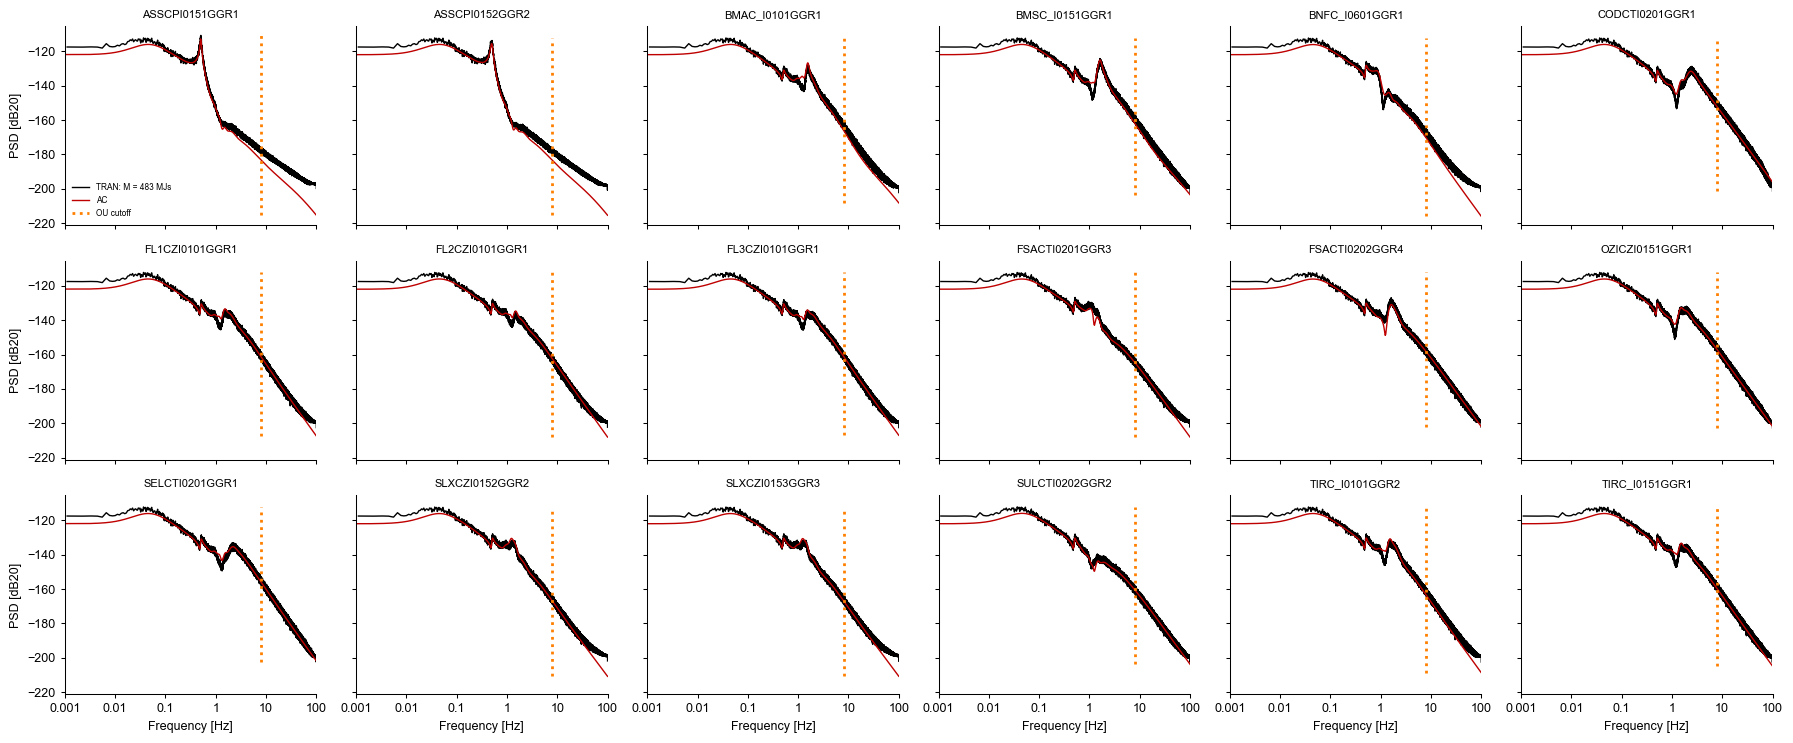

In [7]:
device_names = tran_blobs[0]['device_names'].item()['gen']
if len(device_names) == 10:
    rows,cols = 2,5
    w,h = 3,2.5
elif len(device_names) == 18:
    rows,cols = 3,6
    w,h = 3,2.5
elif len(device_names) == 1:
    rows,cols = 1,1
    w,h = 5,4
fig,ax = plt.subplots(rows, cols, figsize=(cols*w, rows*h), sharex=True, sharey=True, squeeze=False)
ticks = np.logspace(-3, 2, 6)
F0 = 0.1
red,green,magenta,orange = [0.75,0,0], [0,.75,0], [.75,0,.75], [1,.5,0]
col = [green,magenta]
cmap = plt.get_cmap('tab10', len(AC_data))
lw = 1
AC_freq = AC_data['F']
for k,name in enumerate(device_names[:rows*cols]):
    i,j = k//cols, k%cols
    try:
        ### 1
        idx = device_names.index(name)
        y = 10 * np.log10(tran_Pxx[:,idx])
        ym,yM = y.min(),y.max()
        ax[i,j].semilogx(tran_freq, y, 'k', lw=lw, label='TRAN: M = {:.0f} MJs'.format(M))
        ### 2
        idx = np.where(AC_data['SM_names'] == name)[0][0]
        y = AC_data['mag'][:,idx]
        if y.min() < ym:
            ym = y.min()
        if y.max() > yM:
            yM = y.max()
        ax[i,j].semilogx(AC_freq, y, color=red, lw=1, label='AC')
        ### 3
        ax[i,j].plot(1/(2*np.pi*OU_tau)+np.zeros(2), [ym,yM], ':', color=orange, lw=2, label='OU cutoff')
        ax[i,j].set_title(name.split('___')[0], fontsize=8)
        ax[i,j].xaxis.set_major_locator(FixedLocator(ticks))
        ax[i,j].xaxis.set_minor_locator(NullLocator())
        ax[i,j].xaxis.set_major_formatter(FixedFormatter([f'{tick:g}' for tick in ticks]))
        ax[i,j].set_xlim(ticks[[0,-1]])
    except:
        print(f'Device name {name} missing')
ax[0,0].legend(loc='lower left', frameon=False, fontsize=6)
for a in ax[-1,:]:
    a.set_xlabel('Frequency [Hz]')
for a in ax[:,0]:
    a.set_ylabel(f'PSD [dB{dB}]')
sns.despine()
fig.tight_layout()
plt.savefig(outfile + '.pdf')